# Imports

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torch.nn as F
import torchvision.transforms as transforms
import torchmetrics
import numpy as np

print(torch.version.cuda)

12.1


# Set Device

In [2]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# Import MNIST Dataset

In [3]:
batch_size = 64

train_dataset = datasets.CIFAR100(root = './data',
                               train = True,
                               transform = transforms.Compose([
                                   transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std = (0.3105,))]),
                               download = True
                               )

test_dataset = datasets.CIFAR100(root='./data',
                               train=False,
                               transform=transforms.Compose([
                                   transforms.Resize((32, 32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.1325,), std=(0.3105,))]),
                               download=True
                               )
        
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Set up the LeNet CNN

In [4]:
class LeNet_mod(F.Module):
    def __init__(self, num_classes):
        super(LeNet_mod, self).__init__()
        self.layer1 = F.Sequential(
            F.Conv2d(3, 13, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(13),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = F.Sequential(
            F.Conv2d(13, 60, kernel_size = 5, stride=1, padding = 0),
            F.BatchNorm2d(60),
            F.ReLU(),
            F.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = F.Linear(1500,360)
        self.relu = F.ReLU()
        self.fc1 = F.Linear(360,256)
        self.relu1 = F.ReLU()
        self.fc2 = F.Linear(256,num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# Epoch tests
### Hyperparameters

In [5]:
num_classes = 100
learning_rate = 0.001
num_epochs = 30

metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

### Set up the CNN for use

In [6]:
model = LeNet_mod(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

total_step = len(train_loader)

accuracy = []

f1 = []

### Run the CNN
Record the accuracy at the end of each epoch

In [7]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy.append(100 * correct / total)
        f1.append((100* metric_f1.compute()))
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {f1[-1]:.4f}%')
        print(f'Accuracy: {accuracy[-1]:.4f}%')
        

C:\Users\kylek\OneDrive\Documents\GitHub\MLProj\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/30.. 
F1Score: 4.0260%
Accuracy: 6.8900%
Epoch 2/30.. 
F1Score: 7.5620%
Accuracy: 14.3600%
Epoch 3/30.. 
F1Score: 10.6513%
Accuracy: 19.2100%
Epoch 4/30.. 
F1Score: 13.3705%
Accuracy: 22.7200%
Epoch 5/30.. 
F1Score: 15.8468%
Accuracy: 26.6200%
Epoch 6/30.. 
F1Score: 18.0893%
Accuracy: 29.4000%
Epoch 7/30.. 
F1Score: 20.0254%
Accuracy: 31.8000%
Epoch 8/30.. 
F1Score: 21.7925%
Accuracy: 32.6700%
Epoch 9/30.. 
F1Score: 23.3662%
Accuracy: 33.0900%
Epoch 10/30.. 
F1Score: 24.7848%
Accuracy: 34.6400%
Epoch 11/30.. 
F1Score: 26.1031%
Accuracy: 35.8400%
Epoch 12/30.. 
F1Score: 27.3350%
Accuracy: 36.7400%
Epoch 13/30.. 
F1Score: 28.4745%
Accuracy: 36.7800%
Epoch 14/30.. 
F1Score: 29.5463%
Accuracy: 37.7200%
Epoch 15/30.. 
F1Score: 30.5592%
Accuracy: 38.6700%
Epoch 16/30.. 
F1Score: 31.5217%
Accuracy: 39.3800%
Epoch 17/30.. 
F1Score: 32.4384%
Accuracy: 39.1900%
Epoch 18/30.. 
F1Score: 33.3350%
Accuracy: 39.8500%
Epoch 19/30.. 
F1Score: 34.1793%
Accuracy: 40.1000%
Epoch 20/30.. 
F1Score: 

### Graph

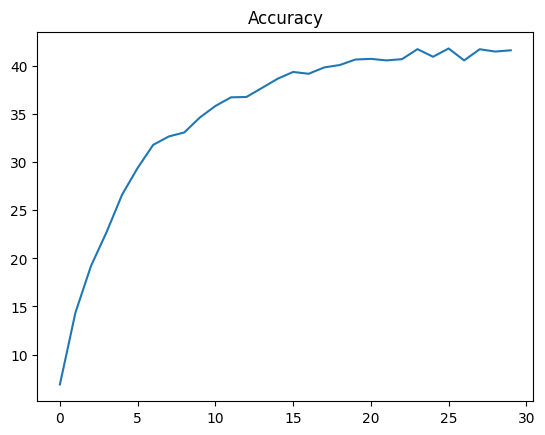

In [8]:
plt.plot(accuracy)
plt.title('Accuracy')
plt.show()

In [9]:
print("Maximum accuracy of the network: {} at epoch {}".format(np.max(accuracy), np.argmax(accuracy)))

Maximum accuracy of the network: 41.82 at epoch 25


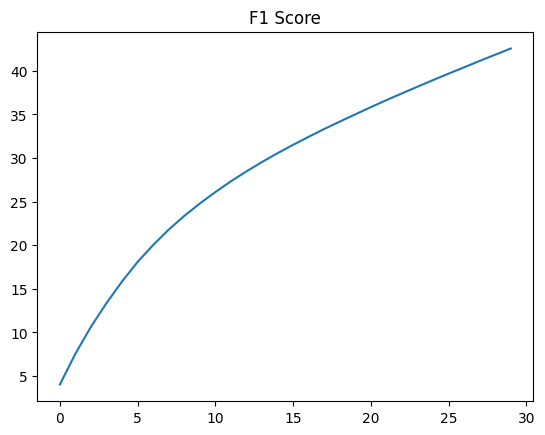

In [10]:
plt.plot(torch.stack(f1).cpu())
plt.title('F1 Score')
plt.show()

# Optimal Learning Rate
### Hyperparameters

In [85]:
batch_size = 64
num_classes = 100
learning_rate = [1,0.1,0.01,0.001,0.0001,0.00001]
num_epochs = 17
error = []
accuracy = []
metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

# Set up and run the CNN
Record the error at the end of each iteration

In [86]:
for i in learning_rate:    
    model = LeNet_mod(num_classes = num_classes).to(device)
    
    cost = F.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=i, momentum=.9)
    
    total_step = len(train_loader)
    error.append([])
    for epoch in range(num_epochs):
        
        for j, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            error[-1].append(loss.item())
            metric_f1.update(outputs, labels)
            
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                _, predicted = torch.max(output.data, 1)
                total+=labels.size(0)
                correct+=(predicted == labels).sum().item()
            accuracy.append(100 * correct / total)
            print(f'Learning Rate {i}.. ')
            print(f'Epoch {epoch+1}/{num_epochs}.. ')
            print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
            print(f'Accuracy: {accuracy[-1]:.4f}%')

Learning Rate 1.. 
Epoch 1/17.. 
F1Score: 1.0080%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 2/17.. 
F1Score: 0.9620%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 3/17.. 
F1Score: 0.9707%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 4/17.. 
F1Score: 0.9815%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 5/17.. 
F1Score: 0.9704%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 6/17.. 
F1Score: 0.9657%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 7/17.. 
F1Score: 0.9717%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 8/17.. 
F1Score: 0.9835%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 9/17.. 
F1Score: 0.9858%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 10/17.. 
F1Score: 0.9868%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 11/17.. 
F1Score: 0.9869%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 12/17.. 
F1Score: 0.9867%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 13/17.. 
F1Score: 0.9922%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 14/17.. 
F1Score: 0.9920%
Accuracy: 1.0000%
Learning Rate 1.. 
Epoch 15/17.. 
F1Score: 

### Graphs

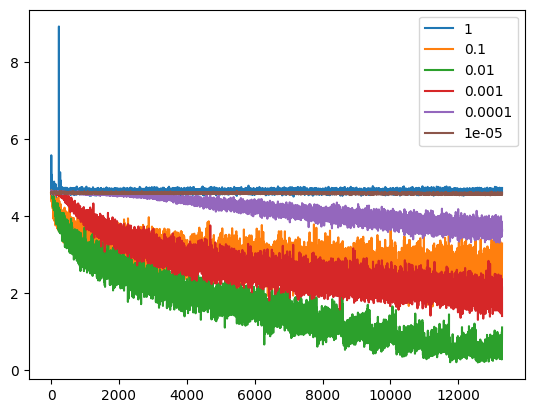

In [87]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

##### Remove the first 2 cases because the scale is thrown off.

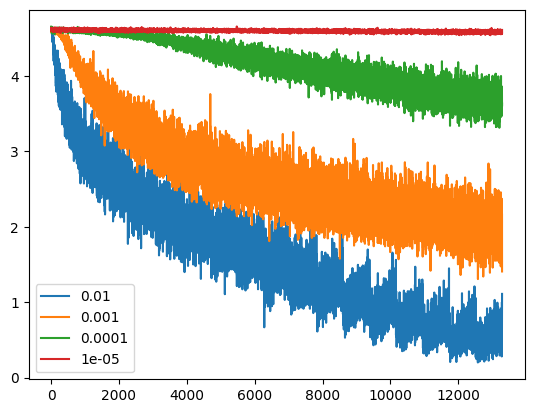

In [88]:
for i in range(2,len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
plt.legend()
plt.show()

##### All Individual graphs

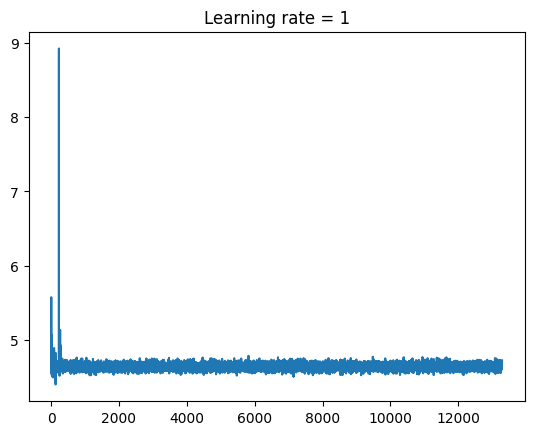

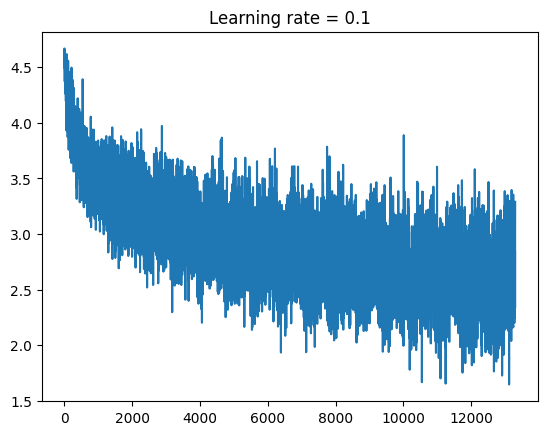

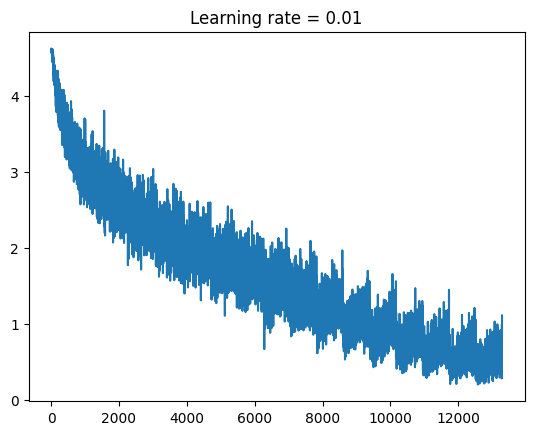

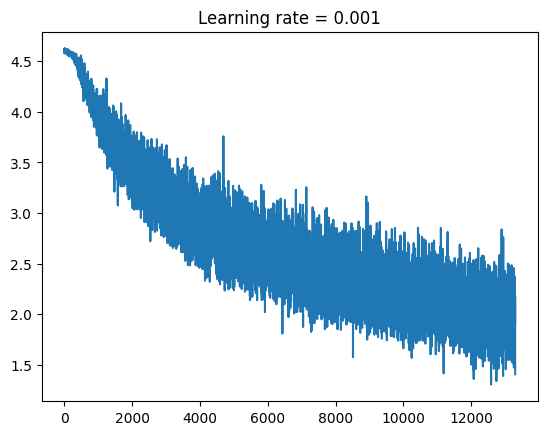

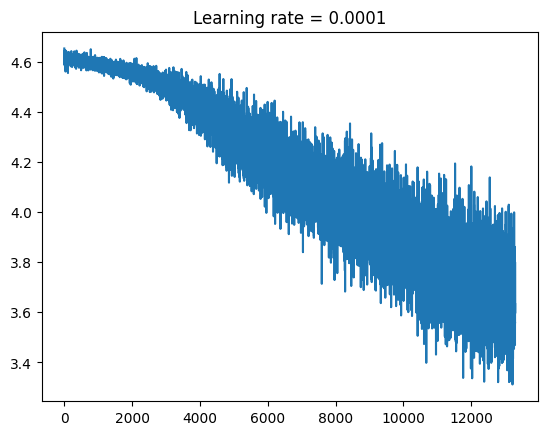

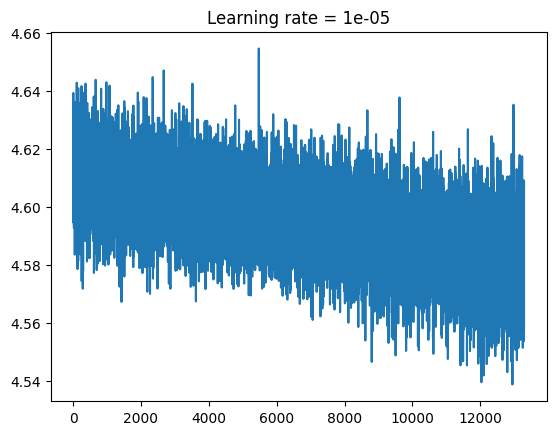

In [89]:
for i in range(len(error)):
    plt.plot(error[i], label='{}'.format(learning_rate[i]))
    plt.title('Learning rate = {}'.format(learning_rate[i]))
    plt.show()

# Adam Vs. SGD

### Hyperparameters

In [90]:
batch_size = 64
num_classes = 100
learning_rate = 0.001
num_epochs = 30
metric_f1 = torchmetrics.F1Score(task='multiclass', num_classes = num_classes).to(device)

### Set up Adam

In [91]:
model = LeNet_mod(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

accuracy = [[],[]]

### Run the CNN with Adam
Record the accuracy at the end of each epoch

In [92]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy[0].append(100 * correct / total)
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
        print(f'Accuracy: {accuracy[0][-1]:.4f}%')

Epoch 1/30.. 
F1Score: 15.5820%
Accuracy: 23.4400%
Epoch 2/30.. 
F1Score: 21.4570%
Accuracy: 30.1000%
Epoch 3/30.. 
F1Score: 25.5573%
Accuracy: 31.9000%
Epoch 4/30.. 
F1Score: 28.8600%
Accuracy: 35.5200%
Epoch 5/30.. 
F1Score: 31.5980%
Accuracy: 37.9000%
Epoch 6/30.. 
F1Score: 34.0080%
Accuracy: 38.7700%
Epoch 7/30.. 
F1Score: 36.2160%
Accuracy: 38.8900%
Epoch 8/30.. 
F1Score: 38.1905%
Accuracy: 39.8200%
Epoch 9/30.. 
F1Score: 40.0584%
Accuracy: 40.6700%
Epoch 10/30.. 
F1Score: 41.8256%
Accuracy: 39.6500%
Epoch 11/30.. 
F1Score: 43.5682%
Accuracy: 39.6600%
Epoch 12/30.. 
F1Score: 45.2320%
Accuracy: 39.5000%
Epoch 13/30.. 
F1Score: 46.8320%
Accuracy: 39.1700%
Epoch 14/30.. 
F1Score: 48.3451%
Accuracy: 38.4100%
Epoch 15/30.. 
F1Score: 49.8055%
Accuracy: 38.1700%
Epoch 16/30.. 
F1Score: 51.2006%
Accuracy: 38.2400%
Epoch 17/30.. 
F1Score: 52.5633%
Accuracy: 38.7700%
Epoch 18/30.. 
F1Score: 53.9043%
Accuracy: 38.4700%
Epoch 19/30.. 
F1Score: 55.1666%
Accuracy: 37.7600%
Epoch 20/30.. 
F1Scor

### Set up SGD

In [93]:
model = LeNet_mod(num_classes = num_classes).to(device)

cost = F.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=.9)

total_step = len(train_loader)

accuracy[1] = []

### Run the CNN with SGD
Record the accuracy at the end of each epoch

In [94]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = cost(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metric_f1.update(outputs, labels)
        
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total+=labels.size(0)
            correct+=(predicted == labels).sum().item()
        accuracy[1].append(100 * correct / total)
        print(f'Epoch {epoch+1}/{num_epochs}.. ')
        print(f'F1Score: {(100* metric_f1.compute()):.4f}%')
        print(f'Accuracy: {accuracy[1][-1]:.4f}%')

Epoch 1/30.. 
F1Score: 64.0415%
Accuracy: 6.6600%
Epoch 2/30.. 
F1Score: 62.3838%
Accuracy: 14.3700%
Epoch 3/30.. 
F1Score: 61.0099%
Accuracy: 19.4300%
Epoch 4/30.. 
F1Score: 59.8501%
Accuracy: 23.2200%
Epoch 5/30.. 
F1Score: 58.8743%
Accuracy: 26.5600%
Epoch 6/30.. 
F1Score: 58.0383%
Accuracy: 29.4100%
Epoch 7/30.. 
F1Score: 57.3296%
Accuracy: 30.1600%
Epoch 8/30.. 
F1Score: 56.7153%
Accuracy: 31.8600%
Epoch 9/30.. 
F1Score: 56.1825%
Accuracy: 33.4300%
Epoch 10/30.. 
F1Score: 55.7180%
Accuracy: 35.0300%
Epoch 11/30.. 
F1Score: 55.3181%
Accuracy: 35.1700%
Epoch 12/30.. 
F1Score: 54.9723%
Accuracy: 36.3800%
Epoch 13/30.. 
F1Score: 54.6830%
Accuracy: 37.2100%
Epoch 14/30.. 
F1Score: 54.4293%
Accuracy: 38.6100%
Epoch 15/30.. 
F1Score: 54.2204%
Accuracy: 39.0000%
Epoch 16/30.. 
F1Score: 54.0502%
Accuracy: 39.3000%
Epoch 17/30.. 
F1Score: 53.9139%
Accuracy: 39.5500%
Epoch 18/30.. 
F1Score: 53.8032%
Accuracy: 39.7300%
Epoch 19/30.. 
F1Score: 53.7254%
Accuracy: 40.5600%
Epoch 20/30.. 
F1Score

### Graph

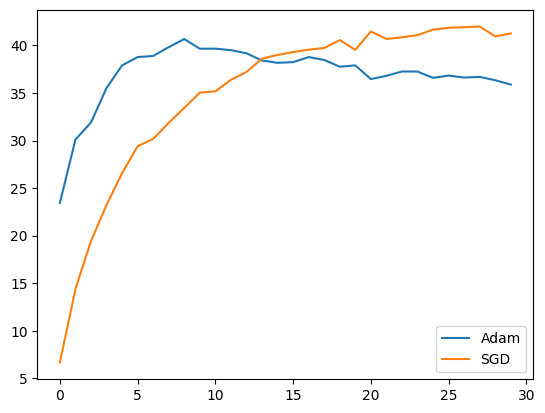

In [95]:
plt.plot(accuracy[0], label='Adam')
plt.plot(accuracy[1], label='SGD')
plt.legend()
plt.show()

In [96]:
print('Adam hits its max accuracy at {} with an accuracy of {}%'.format(np.argmax(accuracy[0]), np.max(accuracy[0])))

Adam hits its max accuracy at 8 with an accuracy of 40.67%


In [97]:
print('SGD hits its max accuracy at {} with an accuracy of {}%'.format(np.argmax(accuracy[1]), np.max(accuracy[1])))

SGD hits its max accuracy at 27 with an accuracy of 41.99%
